1. 환경변수 설정 & 라이브러리 초기화

In [14]:
import os
# MuJoCo를 GPU 없이 EGL 렌더링으로 사용하기 위한 필수 설정
os.environ['MUJOCO_GL'] = 'egl'

import mujoco
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

2. 단순한 MuJoCo XML 모델 정의 (바닥, 조명, 캡슐)

In [15]:
xml = """
<mujoco>
  <worldbody>
    <!-- 위쪽에서 아래로 비추는 조명 -->
    <light pos="0 0 3" dir="0 0 -1" />
    
    <!-- 바닥 plane -->
    <geom name="floor" type="plane" size="1 1 .1" rgba=".8 .9 .8 1"/>

    <!-- 보라색 캡슐 -->
    <geom name="purple_capsule" type="capsule"
          pos=".2 .2 .8" size=".1 .2"
          rgba="0.5 0 0.5 1"/>
  </worldbody>
</mujoco>
"""

3. 모델 로드 & 렌더러 준비

In [16]:
# XML 문자열 파싱 및 MjModel, MjData 인스턴스 생성
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height=480, width=640)

# Forward Dynamics 연산 수행 (현재 상태 갱신)
mujoco.mj_forward(model, data)

# 렌더러에 현재 Scene 상태 반영 및 픽셀 데이터 추출
renderer.update_scene(data)
frame = renderer.render()

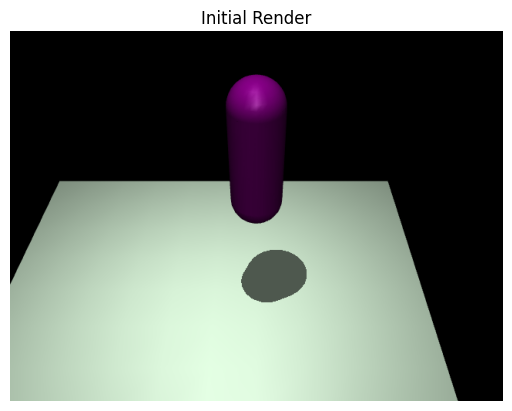

In [17]:
# 결과 시각화
plt.imshow(frame)
plt.title("Initial Render")
plt.axis("off")
plt.show()

4. 모델 내부 구조 조사 (Bodies / Geoms / IDs 등)

In [18]:
print("--- 모델 요약 (Counts) ---")
print(f"Geometries (geom): {model.ngeom}")        # 기하학적 객체 수
print(f"Bodies (body): {model.nbody}")            # 바디(몸체) 수
print(f"Joints (joint): {model.njnt}")            # 관절 수
print(f"Actuators (actuator): {model.nu}")        # 액추에이터(구동기) 수
print(f"Sensors (sensor): {model.nsensor}")       # 센서 수

--- 모델 요약 (Counts) ---
Geometries (geom): 2
Bodies (body): 1
Joints (joint): 0
Actuators (actuator): 0
Sensors (sensor): 0


In [19]:
# Body 목록 출력
if model.nbody > 0:
    print("Body Names:")
    for i in range(model.nbody):
        print(f"  - {model.body(i).name}") 

Body Names:
  - world


In [20]:
# Geom 목록 출력
if model.ngeom > 0:
    print("Geom Names:")
    for i in range(model.ngeom):
        print(f"  - {model.geom(i).name}")

Geom Names:
  - floor
  - purple_capsule


In [21]:
# 특정 geom 조회
model.geom('purple_capsule')

<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 1
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'purple_capsule'
  pos: array([0.2, 0.2, 0.8])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.3])
  rgba: array([0.5, 0. , 0.5, 1. ], dtype=float32)
  sameframe: array([3], dtype=uint8)
  size: array([0.1, 0.2, 0. ])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([3], dtype=int32)
  user: array([], dtype=float64)
>

In [22]:
print('id of "purple_capsule": ', model.geom('purple_capsule').id)
print('name of geom 1: ', model.geom(1).name)
print('name of body 0: ', model.body(0).name)

id of "purple_capsule":  1
name of geom 1:  purple_capsule
name of body 0:  world


In [23]:
# 전체 geom 목록
print("\nList of all geom names:", [model.geom(i).name for i in range(model.ngeom)])


List of all geom names: ['floor', 'purple_capsule']


5. 카메라 직접 제어하면서 애니메이션 생성

In [24]:
duration = 5         # 시뮬레이션 지속 시간 (초)
framerate = 60       # 초당 프레임 수 (FPS)
num_frames = duration * framerate
frames = []

# 커스텀 카메라 인스턴스 생성 (mjvCamera)
cam = mujoco.MjvCamera()

# 카메라 초기 파라미터 설정
cam.lookat = [0.1, 0.1, 0.1]   # 카메라가 바라볼 좌표
cam.distance = 2.0             # 카메라 거리
cam.elevation = -20            # 카메라 고도(위/아래)

In [25]:
# 프레임 생성
for i in range(num_frames):

    # 카메라를 부드럽게 왕복시키는 효과
    cam.distance = 2.0 + 3.0 * np.sin(i / 10)

    # 장면 업데이트 (mj_step 대신 mj_forward 사용: 정적 모델이라 step 필요 없음)
    mujoco.mj_forward(model, data)

    # Renderer에 camera 전달
    renderer.update_scene(data, camera=cam)

    # RGB 프레임 추출
    pixels = renderer.render()
    frames.append(pixels)

print("Total frames generated:", len(frames))

Total frames generated: 300


In [26]:
media.show_video(frames, fps=framerate)